In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import time

In [2]:
rating = pd.read_csv('ratings.csv')

In [3]:
movie_matrix = rating.pivot(index='userId' ,columns='movieId', values='rating')

In [5]:
#nan 값 0으로채우기
movie_matrix = movie_matrix.fillna(0)

In [6]:
movie_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
##dataframe 형태를 np형태로바꾸기
datMat = np.array(movie_matrix,dtype='int64'); 
datMat = datMat[:,1:]

In [8]:
datMat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
def matrix_factorization(R, P, Q, K, steps=30, alpha=0.0002, beta=0.02):
#Step = SGD의 횟수, R = 실제 평점 matrix, 
#P,Q = factorization matrix, 
#alpha =learning late, beta = regularization term.

    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] +alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] +alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e+pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j], 2))
        if e < 0.001:
            break

    return P, Q.T

In [10]:
##원래 매트릭스를 작은 2개로 나누기  
N, M = datMat.shape
K = 10
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

In [11]:
##q와p를 최적화 한 원래 matrix와 비슷하게 newQ와 newP로 바꾸기
ini = time.time()
newP, newQ = matrix_factorization(datMat, P, Q, K)
end = time.time()

In [12]:
print(end-ini)

374.83560132980347


In [13]:
new_dat = np.dot(newP, newQ.T)

In [14]:
new_dat

array([[2.64096688, 2.9121208 , 2.26045838, ..., 2.08635474, 2.81184334,
        3.51794533],
       [3.36162484, 3.86607666, 3.36593867, ..., 2.10499839, 2.81762997,
        4.44197064],
       [3.12383607, 3.07384672, 3.05140011, ..., 2.25773028, 2.78262589,
        4.2570529 ],
       ...,
       [3.19111466, 3.33279384, 2.994656  , ..., 1.86698869, 2.88409761,
        4.33640866],
       [3.2351656 , 2.96923542, 2.69569973, ..., 2.48588478, 3.64020601,
        4.67080558],
       [3.28842632, 3.193948  , 2.72107664, ..., 2.53017081, 3.70776723,
        4.70661322]])

In [15]:
## 원래 매트릭스와 newQ와newP의곱의 error를 계산하기 
total_count = 0
total_error = 0
for u in range(N):
    err_u = 0
    rateCount_u = 0
    for j in range(M):
        if datMat[u,j] > 0:
            rateCount_u += 1
            err_u += abs(np.dot(newP[u], newQ[j])-datMat[u,j])
    total_count += rateCount_u
    total_error += err_u
print("Overal MAE: %0.3f" % (total_error/total_count))

Overal MAE: 0.710


In [16]:
####파라미터 조절하기
step = [5,10,15,20,25,30,35,40]
for i in step:
    def matrix_factorization(R, P, Q, K, steps=i, alpha=0.0002, beta=0.02):
    #Step = SGD의 횟수, R = 실제 평점 matrix, 
    #P,Q = factorization matrix, 
    #alpha =learning late, beta = regularization term.

        Q = Q.T
        for step in range(steps):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        for k in range(K):
                            P[i][k] = P[i][k] +alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                            Q[k][j] = Q[k][j] +alpha * (2 * eij * P[i][k] - beta * Q[k][j])
            eR = np.dot(P,Q)
            e = 0
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        e = e+pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                        for k in range(K):
                            e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j], 2))
            if e < 0.001:
                break

        return P, Q.T
    ini = time.time()
    newP, newQ = matrix_factorization(datMat, P, Q, K)
    end = time.time()
    total_count = 0
    total_error = 0
    for u in range(N):
        err_u = 0
        rateCount_u = 0
        for j in range(M):
            if datMat[u,j] > 0:
                rateCount_u += 1
                err_u += abs(np.dot(newP[u], newQ[j])-datMat[u,j])
        total_count += rateCount_u
        total_error += err_u
    print("Overal MAE: %0.3f" % (total_error/total_count))

Overal MAE: 0.700
Overal MAE: 0.687
Overal MAE: 0.673
Overal MAE: 0.660
Overal MAE: 0.650
Overal MAE: 0.640
Overal MAE: 0.630
Overal MAE: 0.620


In [ ]:
## step =40일때 최소값이 나옴  -> step이 점점 증가할수록 total_error가줄어듬

In [18]:
####파라미터 조절하기
step = [35,40,45,50,55]
step_data =[]
accuracy = []
for i in step:
    step_data.append(i)
    def matrix_factorization(R, P, Q, K, steps=i, alpha=0.0002, beta=0.02):
    #Step = SGD의 횟수, R = 실제 평점 matrix, 
    #P,Q = factorization matrix, 
    #alpha =learning late, beta = regularization term.
       
        Q = Q.T
        for step in range(steps):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        for k in range(K):
                            P[i][k] = P[i][k] +alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                            Q[k][j] = Q[k][j] +alpha * (2 * eij * P[i][k] - beta * Q[k][j])
            eR = np.dot(P,Q)
            e = 0
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        e = e+pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                        for k in range(K):
                            e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j], 2))
            if e < 0.001:
                break

        return P, Q.T
    ini = time.time()
    newP, newQ = matrix_factorization(datMat, P, Q, K)
    end = time.time()
    total_count = 0
    total_error = 0
    for u in range(N):
        err_u = 0
        rateCount_u = 0
        for j in range(M):
            if datMat[u,j] > 0:
                rateCount_u += 1
                err_u += abs(np.dot(newP[u], newQ[j])-datMat[u,j])
        total_count += rateCount_u
        total_error += err_u
    accuracy.append((total_error/total_count))
    print("Overal MAE: %0.3f" % (total_error/total_count))

Overal MAE: 0.612
Overal MAE: 0.602
Overal MAE: 0.591
Overal MAE: 0.579
Overal MAE: 0.566


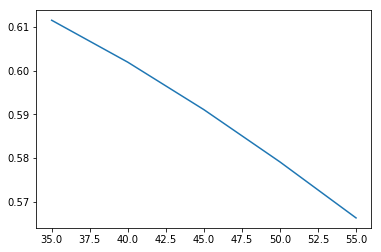

In [19]:
x = step_data
y = accuracy
plt.plot(x,y)
#


In [20]:
####파라미터 조절하기
step = [60,65,70,75,80,85]
step_data =[]
accuracy = []
for i in step:
    step_data.append(i)
    def matrix_factorization(R, P, Q, K, steps=i, alpha=0.0002, beta=0.02):
    #Step = SGD의 횟수, R = 실제 평점 matrix, 
    #P,Q = factorization matrix, 
    #alpha =learning late, beta = regularization term.
       
        Q = Q.T
        for step in range(steps):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        for k in range(K):
                            P[i][k] = P[i][k] +alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                            Q[k][j] = Q[k][j] +alpha * (2 * eij * P[i][k] - beta * Q[k][j])
            eR = np.dot(P,Q)
            e = 0
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        e = e+pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                        for k in range(K):
                            e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j], 2))
            if e < 0.001:
                break

        return P, Q.T
    ini = time.time()
    newP, newQ = matrix_factorization(datMat, P, Q, K)
    end = time.time()
    total_count = 0
    total_error = 0
    for u in range(N):
        err_u = 0
        rateCount_u = 0
        for j in range(M):
            if datMat[u,j] > 0:
                rateCount_u += 1
                err_u += abs(np.dot(newP[u], newQ[j])-datMat[u,j])
        total_count += rateCount_u
        total_error += err_u
    accuracy.append((total_error/total_count))
    print("Overal MAE: %0.3f" % (total_error/total_count))

Overal MAE: 0.553
Overal MAE: 0.540
Overal MAE: 0.527
Overal MAE: 0.515
Overal MAE: 0.503
Overal MAE: 0.492


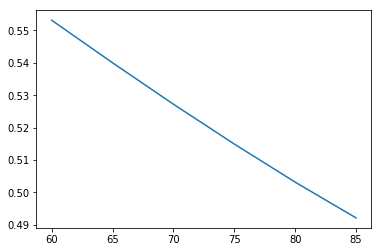

In [21]:
x = step_data
y = accuracy
plt.plot(x,y)
#
#step = SGD의 횟수 가 많을수록 오류가 적어진다 
#하지만 시간이 늘어난다 .
